In [2]:
import numba
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp

In [3]:
from scipy.sparse import random
from scipy import stats
from numpy.random import default_rng
rng = default_rng()
rvs = stats.uniform().rvs
# rvs = stats.poisson(5, loc=10).rvs
X = random(20, 100, density=0.25, random_state=rng, data_rvs=rvs)
X.A

array([[0.        , 0.        , 0.        , ..., 0.07096323, 0.        ,
        0.        ],
       [0.        , 0.07595765, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.5974677 , ..., 0.82125593, 0.        ,
        0.24565065],
       ...,
       [0.        , 0.4782764 , 0.31220619, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

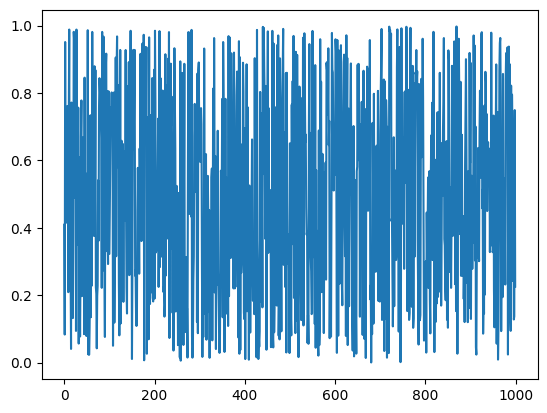

In [4]:
np.random.uniform(0,1,100)
s = np.random.default_rng().uniform(0,1,1000)


n = 20
p = 50

X = np.reshape(s,(-1, p))
X.shape
df = pd.DataFrame(X)
#  we let r=25

y = np.zeros(n) #initialising y array
for i in range(n):
    yTemp = df.iloc[i,0:25].sum() + np.random.normal(0,1) #generating y values from a simple linear model with gaussian noise
    y[i] = yTemp

plt.plot(s)

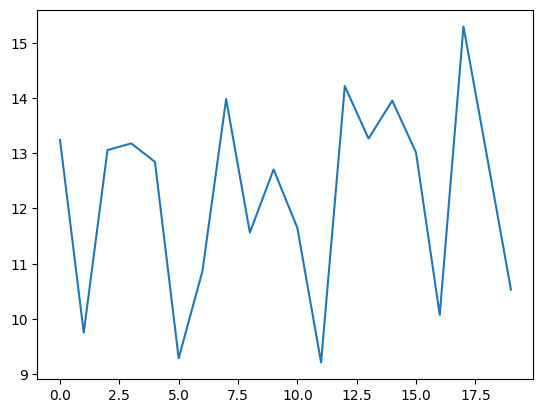

In [5]:
plt.plot(y)

In [6]:
param = dict(sigma1=1, sigma2=1, sigmay=1, p=100)

In [7]:
def multGaussian(X, mu,sigma):
    m = len(mu)
    sigma2 = np.diag(sigma)
    X = X-mu.T
    p = 1/((2*np.pi)**(m/2)*np.linalg.det(sigma2)**(0.5)) * np.exp(-0.5*np.sum(X.dot(np.linalg.pinv(sigma2))*X,axis=1))
    return p

In [8]:
def diracDelta(x, eps):
    return 1.0/(eps*np.sqrt(2.*np.pi)) * np.exp(-x**2/(2.*eps**2))
diracDelta = np.vectorize(diracDelta)

diracDelta(y, 10)
# plt.plot(y, diracDelta(y,10))

array([0.01660514, 0.02479661, 0.01701094, 0.01674217, 0.01748647,
       0.0259159 , 0.02211366, 0.01501142, 0.02044083, 0.01779474,
       0.02023923, 0.02609859, 0.01452463, 0.01655059, 0.01507244,
       0.01710588, 0.02401608, 0.01238705, 0.01730314, 0.0229105 ])

In [45]:
s = np.random.uniform()
s

0.45390655779632183

In [ ]:
sigma1 = 1
sigma2 = 0.1
sigmay = 1
niter = 10
gamma = 0.1


p = len(X[1])
n = len(X)
b = p + n
rho = 1
theta = np.zeros(b)
z = np.zeros(b)
for t in range(niter):
    for i in range(b):
        if i <= p:
            e = np.zeros(p)
            e[i] = 1
            A = e * 1/sigma2
            sigsig = sigma2 / sigma1
            w1 = gamma * sigsig / ((gamma * sigsig)+((1-gamma)*np.exp(-(1-sigsig**2)*np.linalg.norm(A*theta)/2)))
            w2 = 1 - w1
            U = np.random.uniform()
            if U > w1:
                mu = (1 - sigsig**2) * (A*theta)
                sigmaz = 1 - sigsig**2
                z[i] = np.random.normal(mu, sigmaz)
            else:
                z[i] = 0
        else:
            X_t = X[i]
            A = X_t / sigmay
    

In [ ]:
def splitGibbs(sigma1, sigma2, sigmay, p, iter=1000):
    rho = 1
    theta0 = 0
    for t in range(iter):
        if i <= p:
            e = np.zeros(p)
            e[i] = 1
            A = e * 1/sigma2
            if
        else:
            X_t = X[i]
            A = X_t / sigmay

In [ ]:
def effectiveSampleSize(data, stepSize = 1) :
  """ Effective sample size, as computed by BEAST Tracer."""
  samples = len(data)

  assert len(data) > 1,"no stats for short sequences"
  
  maxLag = min(samples//3, 1000)

  gammaStat = [0,]*maxLag
  #varGammaStat = [0,]*maxLag

  varStat = 0.0;

  if type(data) != np.ndarray :
    data = np.array(data)

  normalizedData = data - data.mean()
  
  for lag in range(maxLag) :
    v1 = normalizedData[:samples-lag]
    v2 = normalizedData[lag:]
    v = v1 * v2
    gammaStat[lag] = sum(v) / len(v)
    #varGammaStat[lag] = sum(v*v) / len(v)
    #varGammaStat[lag] -= gammaStat[0] ** 2

    # print lag, gammaStat[lag], varGammaStat[lag]
    
    if lag == 0 :
      varStat = gammaStat[0]
    elif lag % 2 == 0 :
      s = gammaStat[lag-1] + gammaStat[lag]
      if s > 0 :
         varStat += 2.0*s
      else :
        break
      
  # standard error of mean
  # stdErrorOfMean = Math.sqrt(varStat/samples);

  # auto correlation time
  act = stepSize * varStat / gammaStat[0]

  # effective sample size
  ess = (stepSize * samples) / act

  return ess